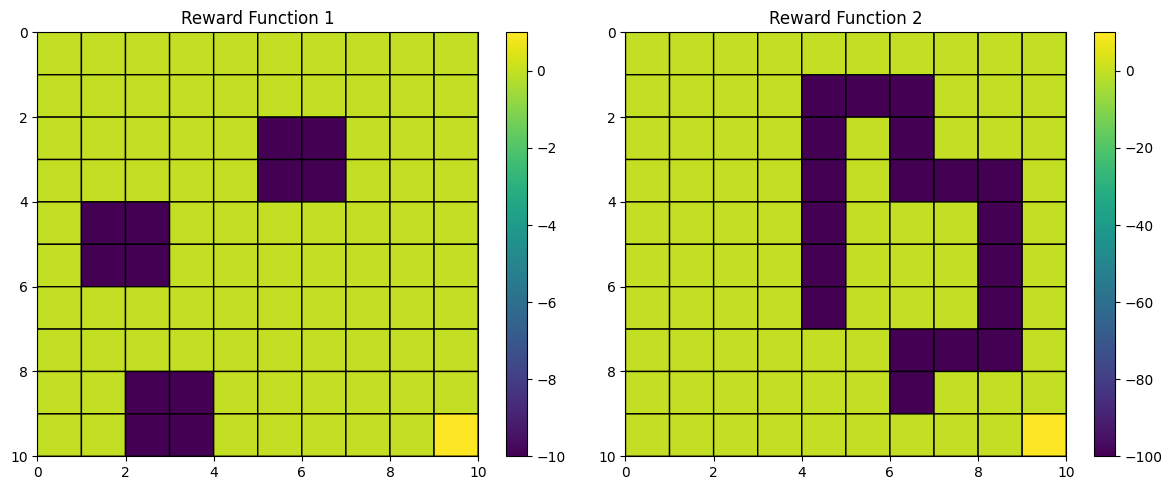

In [1]:
import numpy as np
import matplotlib.pyplot as plt


reward_1 = np.zeros((10, 10))
reward_1[2:4,5:7] = -10
reward_1[4:6,1:3] = -10
reward_1[8:10,2:4] = -10
reward_1[9, 9] = 1


reward_2 = np.zeros((10, 10))
reward_2[1:7, 4] = -100
reward_2[1, 5] = -100
reward_2[1:9, 6] = -100
reward_2[3:8, 7:9] = -100
reward_2[4:7, 6:8] = 0
reward_2[9, 9] = 10


fig, axs = plt.subplots(1, 2, figsize=(12, 5))

c1 = axs[0].pcolor(reward_1, edgecolors='k', linewidth=1)
axs[0].invert_yaxis()  # Make top row = index 0
axs[0].set_title("Reward Function 1")
fig.colorbar(c1, ax=axs[0])

c2 = axs[1].pcolor(reward_2, edgecolors='k', linewidth=1)
axs[1].invert_yaxis()
axs[1].set_title("Reward Function 2")
fig.colorbar(c2, ax=axs[1])

plt.tight_layout()
plt.show()


In [2]:
%pip install cvxopt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\h'h'h\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [3]:
class GridMDP:
    def __init__(self, grid_size=10, w=0.1, gamma=0.8):
        self.grid_size = grid_size
        self.n_states = grid_size * grid_size
        self.actions = ['up', 'down', 'left', 'right']
        self.w = w
        self.gamma = gamma
        self.reward = self._build_reward()

    def _build_reward(self):
        r = np.zeros((self.grid_size, self.grid_size))
        r[9, 9] = 1.0
        traps = [(2, 6), (2, 7),
                (3, 6), (3, 7),
                (4, 1), (4, 2),
                (5, 1), (5, 2),
                (8, 2), (8, 3),
                (9, 2), (9, 3)]

        for i, j in traps:
            r[i, j] = -10.0

        return r.flatten()


    def state_to_coord(self, s):
        return divmod(s, self.grid_size)

    def coord_to_state(self, i, j):
        return i * self.grid_size + j

    def transition_probs(self, s, a):
        i, j = self.state_to_coord(s)
        neighbors = {
            'up': (max(i-1, 0), j),
            'down': (min(i+1, self.grid_size - 1), j),
            'left': (i, max(j-1, 0)),
            'right': (i, min(j+1, self.grid_size - 1))
        }
        probs = {}
        for dir in self.actions:
            ns = self.coord_to_state(*neighbors[dir])
            if dir == a:
                probs[ns] = probs.get(ns, 0) + (1 - self.w)
            else:
                probs[ns] = probs.get(ns, 0) + self.w / 3
        return probs.items()


In [4]:
def optimal_state_value(env, epsilon=0.01):
    V = np.zeros(env.n_states)
    history = []
    delta = float('inf')
    N = 0

    while delta > epsilon:
        V_new = np.zeros_like(V)
        delta = 0
        for s in range(env.n_states):
            v = V[s]
            V_new[s] = max(
                sum(p * (env.reward[s_next] + env.gamma * V[s_next])
                    for s_next, p in env.transition_probs(s, a))
                for a in env.actions
            )
            delta = max(delta, abs(v - V_new[s]))
        V = V_new.copy()
        history.append(V.reshape((10, 10)))
        N += 1

    print(f"Value iteration converged in {N} steps.")
    return V.reshape((10, 10)), history, N




Value iteration converged in 22 steps.


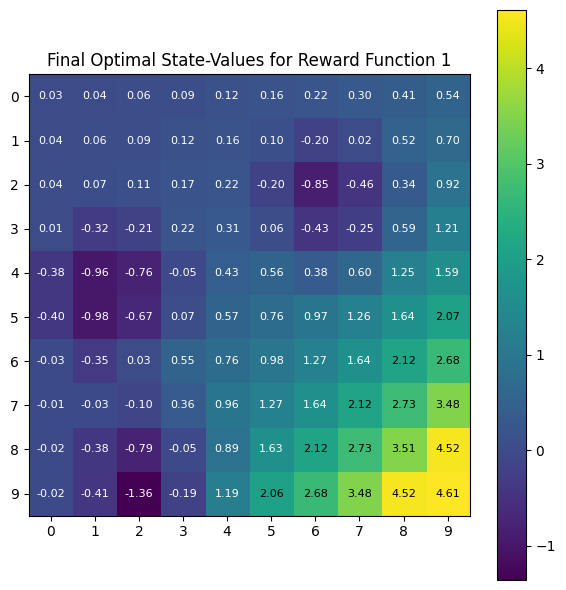

In [5]:
env = GridMDP()
final_V, history, N = optimal_state_value(env)


plt.figure(figsize=(6, 6))
plt.title("Final Optimal State-Values for Reward Function 1")
plt.imshow(final_V, cmap='viridis', origin='lower')
plt.colorbar()


for i in range(10):
    for j in range(10):
        val = final_V[i, j]
        plt.text(j, i, f"{val:.2f}", ha='center', va='center',
                 fontsize=8, color='white' if val < 2 else 'black')

plt.xticks(range(10))
plt.yticks(range(10))
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()


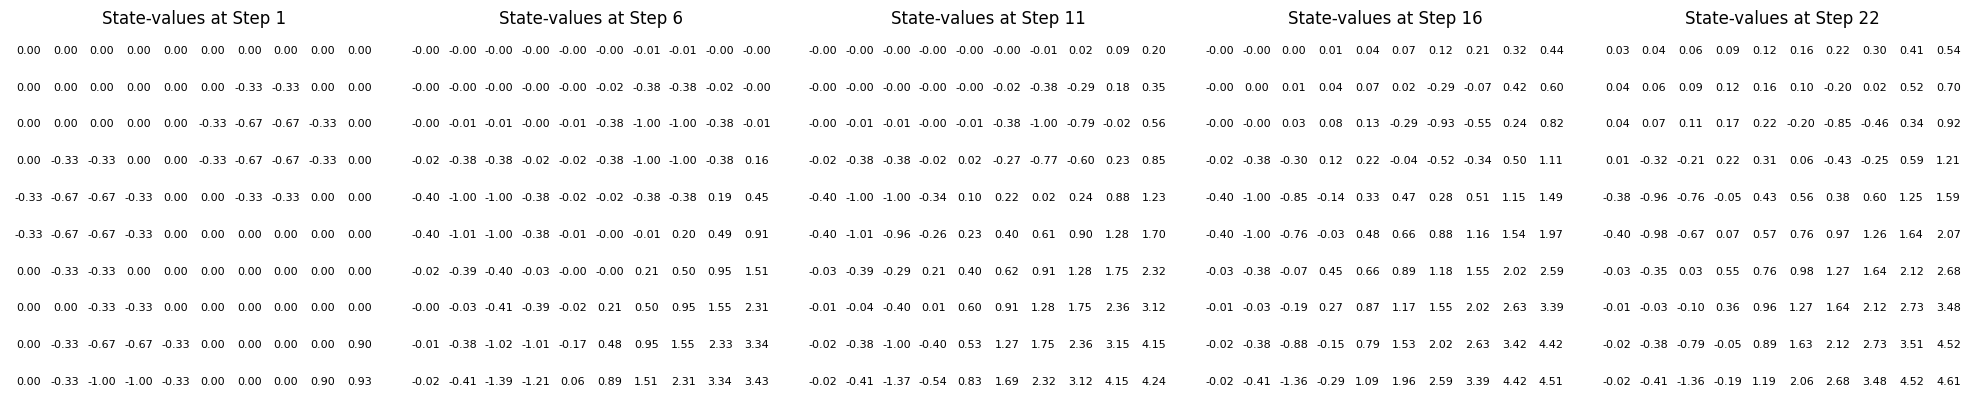

In [6]:
steps = np.linspace(1, N, 5, dtype=int)
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for idx, step in enumerate(steps):
    mat = history[step - 1]
    axs[idx].set_title(f"State-values at Step {step}")
    axs[idx].axis("off")
    for i in range(10):
        for j in range(10):
            val = mat[i, j]
            axs[idx].text(j + 0.5, i + 0.5, f"{val:.2f}", ha='center', va='center', fontsize=8)
    axs[idx].set_xlim(0, 10)
    axs[idx].set_ylim(0, 10)
    axs[idx].invert_yaxis()
    axs[idx].set_aspect('equal')

plt.tight_layout()
plt.show()

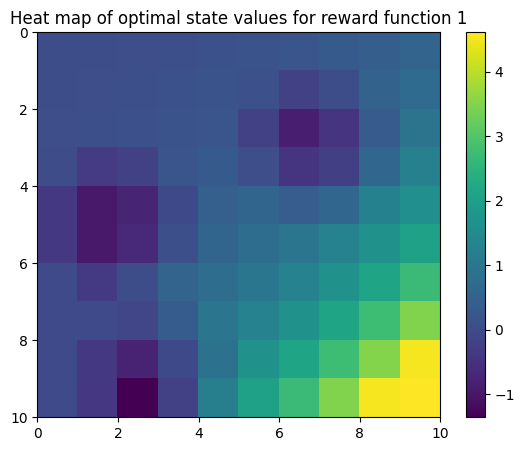

In [7]:
fig, ax = plt.subplots(1,1,figsize=(6.5,5))
plt.sca(ax)
plt.pcolor(final_V)
ax.invert_yaxis()
plt.title("Heat map of optimal state values for reward function 1")
plt.colorbar()
plt.show()


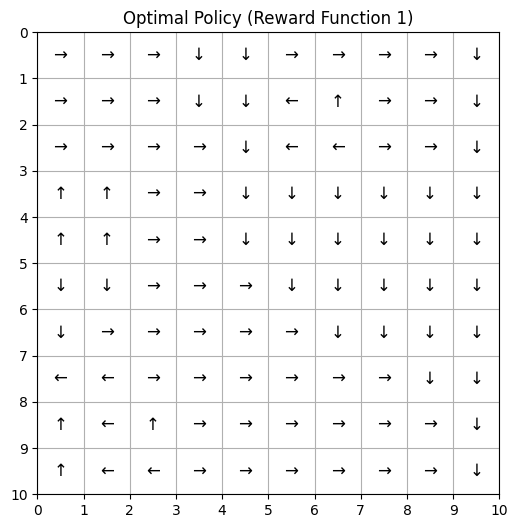

In [8]:
V = final_V.flatten()  # 确保用的是最终收敛的状态值
policy = np.empty(env.n_states, dtype=str)

arrow_map = {
    'up': '↑',
    'down': '↓',
    'left': '←',
    'right': '→'
}

for s in range(env.n_states):
    best_action = None
    best_value = -np.inf
    for a in env.actions:
        val = sum(
            p * (env.reward[s_next] + env.gamma * V[s_next])
            for s_next, p in env.transition_probs(s, a)
        )
        if val > best_value:
            best_value = val
            best_action = a
    policy[s] = arrow_map[best_action]

# Plot
policy_grid = policy.reshape((10, 10))
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Optimal Policy (Reward Function 1)")
ax.set_xticks(np.arange(11))
ax.set_yticks(np.arange(11))
ax.grid(True)

for i in range(10):
    for j in range(10):
        ax.text(j + 0.5, i + 0.5, policy_grid[i, j],
                ha='center', va='center', fontsize=12)

ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_aspect('equal')
ax.invert_yaxis()
plt.show()


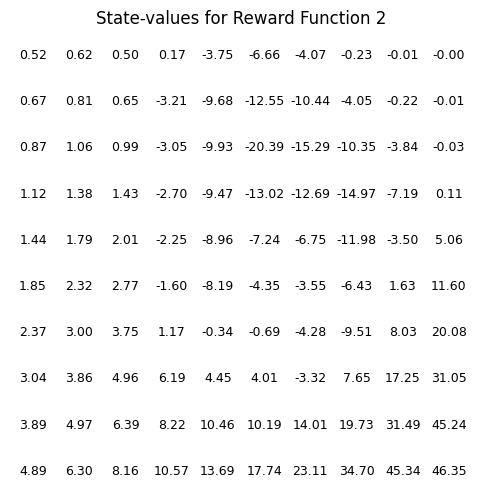

Value iteration converged in 32 steps.


In [9]:
gamma = env.gamma
# Step 1: 替换为 Reward Function 2
reward = reward_2.flatten()

# Step 2: 重新运行 Value Iteration
V = np.zeros(env.n_states)
history = []
delta = float('inf')
N = 0
epsilon = 0.01

while delta > epsilon:
    V_new = np.zeros_like(V)
    delta = 0
    for s in range(env.n_states):
        v = V[s]
        # 直接用 env.transition_probs 而不是 transition_probs
        V_new[s] = max(
            sum(p * (reward[s_next] + gamma * V[s_next])
                for s_next, p in env.transition_probs(s, a))
            for a in env.actions
        )
        delta = max(delta, abs(v - V_new[s]))
    V = V_new.copy()
    history.append(V.reshape((10, 10)))
    N += 1

# Step 3: 可视化含数字的 value map
final_values_rf2 = V.reshape((10, 10))

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("State-values for Reward Function 2")
ax.axis("off")

for i in range(10):
    for j in range(10):
        val = final_values_rf2[i, j]
        ax.text(j + 0.5, i + 0.5, f"{val:.2f}", ha='center', va='center', fontsize=9)

ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.invert_yaxis()
ax.set_aspect('equal')
plt.show()

print(f"Value iteration converged in {N} steps.")


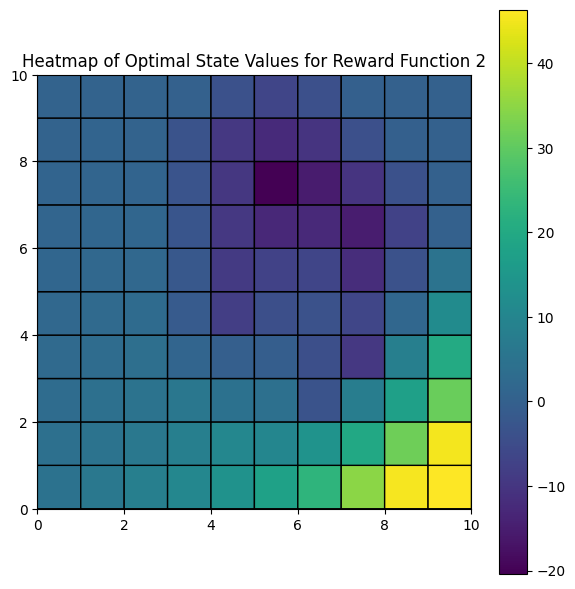

In [10]:
# Heat map of optimal state values for Reward Function 2
fig, ax = plt.subplots(figsize=(6, 6))
c = ax.pcolor(final_values_rf2[::-1], cmap='viridis', edgecolors='k', linewidth=1)
ax.set_title("Heatmap of Optimal State Values for Reward Function 2")
ax.set_aspect('equal')
fig.colorbar(c, ax=ax)
plt.tight_layout()
plt.show()


In [11]:
V_final = final_values_rf2.flatten()  # shape: (100,)


policy_arrows = np.empty((10, 10), dtype=str)

action_map = {
    'up': '↑',
    'down': '↓',
    'left': '←',
    'right': '→',
}


for s in range(env.n_states):
    i, j = env.state_to_coord(s)
    best_action = None
    best_value = float('-inf')

    for a in env.actions:
        value = sum(
            p * (env.reward[s_next] + env.gamma * V_final[s_next])
            for s_next, p in env.transition_probs(s, a)
        )
        if value > best_value:
            best_value = value
            best_action = a

    policy_arrows[i, j] = action_map[best_action]

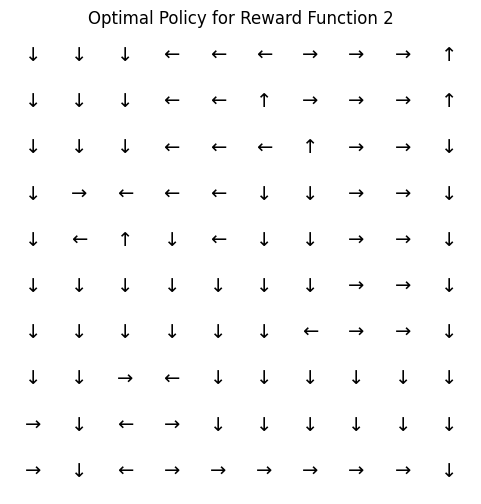

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Optimal Policy for Reward Function 2")
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_aspect('equal')
ax.invert_yaxis()
ax.axis("off")

for i in range(10):
    for j in range(10):
        arrow = policy_arrows[i, j]
        ax.text(j + 0.5, i + 0.5, arrow, ha='center', va='center', fontsize=14)

plt.show()


In [13]:
w = 0.6
gamma = 0.8
epsilon = 0.01
grid_size = 10
n_states = grid_size * grid_size
actions = ['up', 'down', 'left', 'right']
action_arrows = {'up': '↑', 'down': '↓', 'left': '←', 'right': '→'}

# ------------------------
# Helper functions
# ------------------------
def state_to_coord(s): return divmod(s, grid_size)
def coord_to_state(i, j): return i * grid_size + j

def transition_probs(s, a):
    i, j = state_to_coord(s)
    neighbors = {
        'up': (max(i-1,0), j),
        'down': (min(i+1,9), j),
        'left': (i, max(j-1,0)),
        'right': (i, min(j+1,9))
    }
    probs = {}
    for dir in actions:
        ns = coord_to_state(*neighbors[dir])
        probs[ns] = probs.get(ns, 0) + w / 4
    ns_intended = coord_to_state(*neighbors[a])
    probs[ns_intended] += 1 - w
    return probs.items()

def value_iteration(reward_flat):
    V = np.zeros(n_states)
    delta = float('inf')
    while delta > epsilon:
        V_new = np.zeros_like(V)
        delta = 0
        for s in range(n_states):
            v = V[s]
            V_new[s] = max(
                sum(p * (reward_flat[s_next] + gamma * V[s_next])
                    for s_next, p in transition_probs(s, a))
                for a in actions
            )
            delta = max(delta, abs(v - V_new[s]))
        V = V_new.copy()
    return V

def compute_policy(V, reward_flat):
    policy = np.full(n_states, '', dtype=object)
    for s in range(n_states):
        best_action = max(
            actions,
            key=lambda a: sum(p * (reward_flat[s_next] + gamma * V[s_next])
                              for s_next, p in transition_probs(s, a))
        )
        policy[s] = action_arrows[best_action]
    return policy.reshape((10, 10))

def plot_policy_map(policy, title):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title(title)
    ax.axis("off")
    for i in range(10):
        for j in range(10):
            arrow = policy[i, j]
            ax.text(j + 0.5, i + 0.5, arrow, ha='center', va='center', fontsize=12)
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    plt.show()


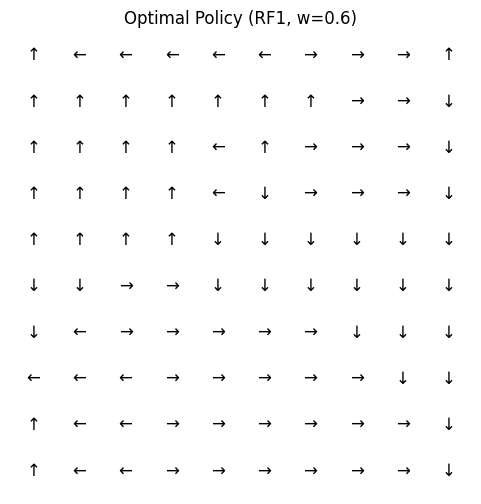

In [14]:
reward_1 = reward_1.flatten()

V1 = value_iteration(reward_1)
policy1 = compute_policy(V1, reward_1)
plot_policy_map(policy1, "Optimal Policy (RF1, w=0.6)")



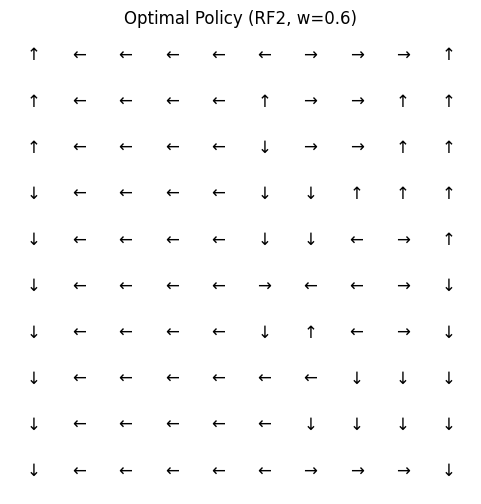

In [15]:
reward_2 = reward_2.flatten()

V2 = value_iteration(reward_2)
policy2 = compute_policy(V2, reward_2)
plot_policy_map(policy2, "Optimal Policy (RF2, w=0.6)")

In [16]:
def value_iteration(reward_flat, w=0.6, gamma=0.8, epsilon=0.01):
    V = np.zeros_like(reward_flat)
    n_states = len(reward_flat)
    grid_size = 10
    actions = ['up', 'down', 'left', 'right']

    def state_to_coord(s): return divmod(s, grid_size)
    def coord_to_state(i, j): return i * grid_size + j

    def transition_probs(s, a):
        i, j = state_to_coord(s)
        neighbors = {
            'up': (max(i - 1, 0), j),
            'down': (min(i + 1, 9), j),
            'left': (i, max(j - 1, 0)),
            'right': (i, min(j + 1, 9))
        }
        probs = {}
        for dir in actions:
            ns = coord_to_state(*neighbors[dir])
            probs[ns] = probs.get(ns, 0) + w / 4
        ns_intended = coord_to_state(*neighbors[a])
        probs[ns_intended] += 1 - w
        return probs.items()

    delta = float('inf')
    while delta > epsilon:
        V_new = np.zeros_like(V)
        delta = 0
        for s in range(n_states):
            v = V[s]
            V_new[s] = max(
                sum(p * (reward_flat[s_next] + gamma * V[s_next])
                    for s_next, p in transition_probs(s, a))
                for a in actions
            )
            delta = max(delta, abs(v - V_new[s]))
        V = V_new

    return V


In [17]:
def plot_value_grid(V, title):
    mat = V.reshape(10, 10)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title(title)
    ax.axis("off")

    for i in range(10):
        for j in range(10):
            val = mat[i, j]
            ax.text(j + 0.5, i + 0.5, f"{val:.2f}", ha='center', va='center', fontsize=9)

    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    plt.show()


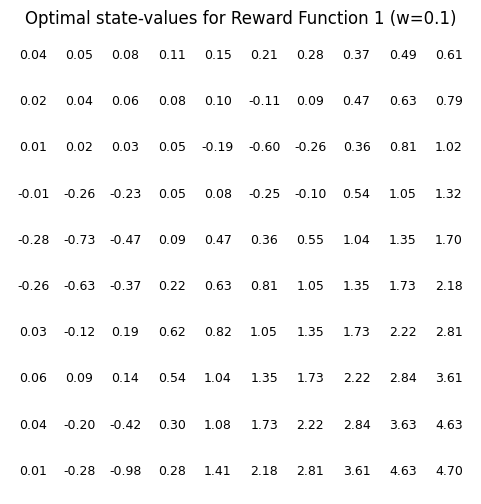

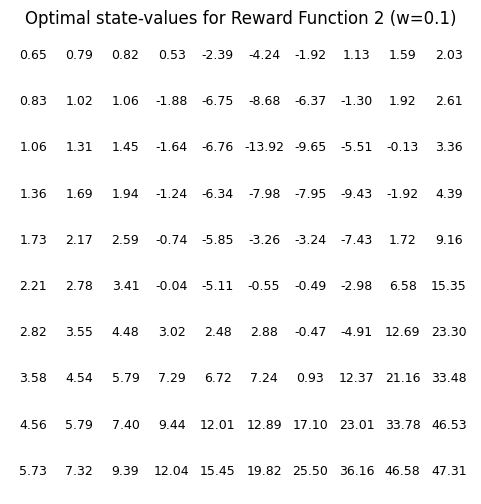

In [18]:
# Reward Function 1
V_rf1 = value_iteration(reward_1.flatten(), w=0.1)
plot_value_grid(V_rf1, "Optimal state-values for Reward Function 1 (w=0.1)")

# Reward Function 2
V_rf2 = value_iteration(reward_2.flatten(), w=0.1)
plot_value_grid(V_rf2, "Optimal state-values for Reward Function 2 (w=0.1)")


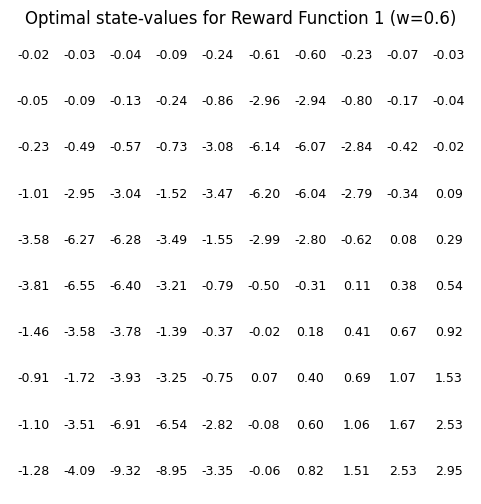

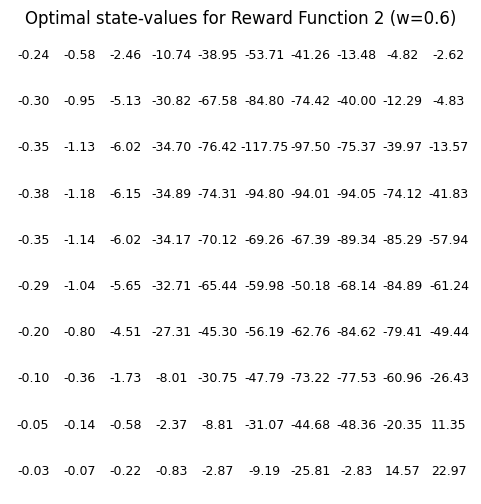

In [19]:
# Reward Function 1
V_rf1 = value_iteration(reward_1.flatten(), w=0.6)
plot_value_grid(V_rf1, "Optimal state-values for Reward Function 1 (w=0.6)")

# Reward Function 2
V_rf2 = value_iteration(reward_2.flatten(), w=0.6)
plot_value_grid(V_rf2, "Optimal state-values for Reward Function 2 (w=0.6)")



In [20]:
!pip install cvxopt


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


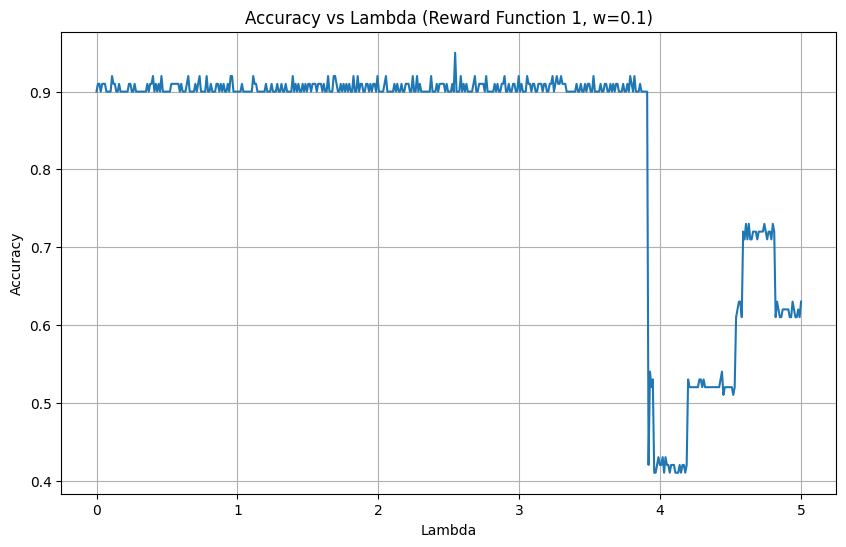

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers

grid_size = 10
w = 0.1 
gamma = 0.8

n_states = grid_size * grid_size
actions = ['up', 'down', 'left', 'right']
action_arrows = {'up': '↑', 'down': '↓', 'left': '←', 'right': '→'}
arrow_to_action = {'↑': 'up', '↓': 'down', '←': 'left', '→': 'right'}

reward_1_grid = np.zeros((10, 10))
reward_1_grid[2:4, 5:7] = -10
reward_1_grid[4:6, 1:3] = -10
reward_1_grid[8:10, 2:4] = -10
reward_1_grid[9, 9] = 1
reward_1_flat = reward_1_grid.flatten()

reward_2_grid = np.zeros((10, 10))
reward_2_grid[1:7, 4] = -100
reward_2_grid[1, 5] = -100
reward_2_grid[1:9, 6] = -100
reward_2_grid[3:8, 7:9] = -100
reward_2_grid[4:7, 6:8] = 0
reward_2_grid[9, 9] = 10
reward_2_flat = reward_2_grid.flatten()


# Define helper functions (refined based on PDF details for transition probabilities)
def state_to_coord(s):
    return divmod(s, grid_size)

def coord_to_state(i, j):
    # Ensure coordinates are within bounds before converting to state index
    i = max(0, min(i, grid_size - 1))
    j = max(0, min(j, grid_size - 1))
    return i * grid_size + j

def transition_probs(s, a, w, grid_size):
    i, j = state_to_coord(s)
    probs_exact = {}
    actions = ['up', 'down', 'left', 'right']

    # Define potential next coordinates for each action
    potential_coords = {
        'up': (i - 1, j),
        'down': (i + 1, j),
        'left': (i, j - 1),
        'right': (i, j + 1)
    }

    # Calculate the actual next state considering boundaries (staying if off-grid)
    def get_actual_next_state_coord(coord):
        ni, nj = coord
        if ni < 0 or ni >= grid_size or nj < 0 or nj >= grid_size:
            return state_to_coord(s) # Stay in the current state (coords) if off-grid
        return (ni, nj)

    # Probability for the intended action
    intended_coord = potential_coords[a]
    actual_intended_coord = get_actual_next_state_coord(intended_coord)
    actual_intended_state = coord_to_state(*actual_intended_coord)
    probs_exact[actual_intended_state] = probs_exact.get(actual_intended_state, 0) + (1 - w)

    # Probabilities for wind blowing in other directions
    for wind_dir in actions:
        wind_coord = potential_coords[wind_dir]
        actual_wind_coord = get_actual_next_state_coord(wind_coord)
        actual_wind_state = coord_to_state(*actual_wind_coord)
        probs_exact[actual_wind_state] = probs_exact.get(actual_wind_state, 0) + w / 4

    return probs_exact.items()

def build_transition_matrix(n_states, actions, w, grid_size):
    P_matrices = {}
    for action in actions:
        P_a = np.zeros((n_states, n_states))
        for s in range(n_states):
            for s_next, p in transition_probs(s, action, w, grid_size):
                P_a[s, s_next] = p
        P_matrices[action] = P_a
    return P_matrices

def value_iteration(reward_flat, w, gamma, epsilon=0.01):
    V = np.zeros_like(reward_flat)
    n_states = len(reward_flat)

    delta = float('inf')
    while delta > epsilon:
        V_new = np.zeros_like(V)
        delta = 0
        for s in range(n_states):
            v = V[s]
            max_q = -np.inf
            for a in actions:
                q_sa = sum(p * (reward_flat[s_next] + gamma * V[s_next])
                           for s_next, p in transition_probs(s, a, w, grid_size))
                max_q = max(max_q, q_sa)
            V_new[s] = max_q
            delta = max(delta, abs(v - V_new[s]))
        V = V_new.copy()
    return V

def compute_policy(V, reward_flat, w, gamma, grid_size, actions, action_arrows):
    policy = np.full(grid_size * grid_size, '', dtype=object)
    n_states = grid_size * grid_size
    for s in range(n_states):
        best_action = None
        best_value = float('-inf')
        for a in actions:
            val = sum(p * (reward_flat[s_next] + gamma * V[s_next])
                      for s_next, p in transition_probs(s, a, w, grid_size))
            if val > best_value:
                best_value = val
                best_action = a
        policy[s] = action_arrows[best_action]
    return policy.reshape((grid_size, grid_size))

def plot_policy_map(policy, title):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title(title)
    ax.axis("off")
    for i in range(10):
        for j in range(10):
            arrow = policy[i, j]
            ax.text(j + 0.5, i + 0.5, arrow, ha='center', va='center', fontsize=12)
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    plt.show()

# Helper to get action name from policy grid arrow
def get_action_name_from_arrow(arrow_string):
    arrow_to_action = {'↑': 'up', '↓': 'down', '←': 'left', '→': 'right'}
    return arrow_to_action[arrow_string]

# Question 11: Inverse Reinforcement Learning (IRL) for Reward Function 1 (w=0.1)

expert_policy_grid_q5 = np.full((10, 10), '→', dtype=str) 

# Build transition matrices for each action with w=0.1
P_matrices_w01 = build_transition_matrix(n_states, actions, w=0.1, grid_size=10)
P_pi_E_w01 = np.zeros((n_states, n_states))
for s in range(n_states):
    expert_action_name = get_action_name_from_arrow(expert_policy_grid_q5.flatten()[s])
    for s_next, p in transition_probs(s, expert_action_name, w=0.1, grid_size=10):
        P_pi_E_w01[s, s_next] = p

I = np.eye(n_states)
Inv_I_minus_gamma_P_pi_E_w01 = np.linalg.inv(I - gamma * P_pi_E_w01)
Inv_I_minus_gamma_P_pi_E_w01_matrix = matrix(Inv_I_minus_gamma_P_pi_E_w01)

R_max = np.max(np.abs(reward_1_grid))

solvers.options.update({'abstol': 1e-7, 'reltol': 1e-6, 'feastol': 1e-7, 'show_progress': False})

# Construct G and h matrices for Gx <= h
G_list = []
h_list = []

# Constraints related to (P_pi_E - P_a)(I - gamma * P_pi_E)^-1 * R >= t and >= 0
# For each state s and each action a != pi_E(s)
for s in range(n_states):
    expert_action_s = get_action_name_from_arrow(expert_policy_grid_q5.flatten()[s])
    for action_name in actions:
        if action_name != expert_action_s:
            P_a = matrix(build_transition_matrix(n_states, actions, w=0.1, grid_size=10)[action_name])
            M_s_a_row = np.array((P_pi_E_w01[s, :] - P_a[s, :]) @ Inv_I_minus_gamma_P_pi_E_w01)[0]

            # Constraint 1: -M_a R + t <= 0 (specifically for row s)
            g1_row = np.zeros(3 * n_states)
            g1_row[0:n_states] = -M_s_a_row
            g1_row[n_states + s] = 1 # t_s
            G_list.append(g1_row)
            h_list.append(0)

            # Constraint 2: -M_a R <= 0 (specifically for row s)
            g2_row = np.zeros(3 * n_states)
            g2_row[0:n_states] = -M_s_a_row
            G_list.append(g2_row)
            h_list.append(0)

# Constraints R - u <= 0 and -R - u <= 0
for s in range(n_states):
    g3_row = np.zeros(3 * n_states)
    g3_row[s] = 1 
    g3_row[2 * n_states + s] = -1 
    G_list.append(g3_row)
    h_list.append(0)

    g4_row = np.zeros(3 * n_states)
    g4_row[s] = -1 
    g4_row[2 * n_states + s] = -1 
    G_list.append(g4_row)
    h_list.append(0)

# Constraints R <= R_max and -R <= R_max
for s in range(n_states):
    g5_row = np.zeros(3 * n_states)
    g5_row[s] = 1 
    G_list.append(g5_row)
    h_list.append(R_max)

    g6_row = np.zeros(3 * n_states)
    g6_row[s] = -1 
    G_list.append(g6_row)
    h_list.append(R_max)

G = matrix(np.array(G_list))
h = matrix(np.array(h_list))

lambda_values = np.linspace(0, 5, 500)
accuracy_values = []



for lambda_val in lambda_values:
    # Construct c vector for minimize -c^T x
    c_vector = np.zeros(3 * n_states)
    c_vector[n_states:2*n_states] = -1 
    c_vector[2*n_states:3*n_states] = lambda_val
    c = matrix(c_vector)

    # Solve the LP
    sol = solvers.lp(c, G, h)

    # Extract the learned reward function R
    if sol['status'] == 'optimal':
        R_learned = np.array(sol['x'][0:n_states]).flatten()

        # Compute the optimal policy (O_A) using the learned reward function R_learned
        V_learned = value_iteration(R_learned, w=0.1, gamma=0.8, epsilon=0.01) # Reuse value_iteration with w=0.1
        policy_learned_grid = compute_policy(V_learned, R_learned, w=0.1, gamma=0.8, grid_size=10, actions=actions, action_arrows=action_arrows) # Reuse compute_policy

        # Compute accuracy (Equation 3)
        match_count = 0
        for s in range(n_states):
            expert_action_q5 = get_action_name_from_arrow(expert_policy_grid_q5.flatten()[s])
            learned_action = get_action_name_from_arrow(policy_learned_grid.flatten()[s])
            if expert_action_q5 == learned_action:
                match_count += 1
        accuracy = match_count / n_states
        accuracy_values.append(accuracy)
    else:
        # If LP doesn't find an optimal solution, append NaN for accuracy
        accuracy_values.append(np.nan)

# Plot lambda vs Accuracy
plt.figure(figsize=(10, 6))
plt.plot(lambda_values, accuracy_values)
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Lambda (Reward Function 1, w=0.1)')
plt.grid(True)
plt.show()

In [22]:
# Question 12: Find lambda_max for Reward Function 1 (w=0.1)

# Find the lambda value corresponding to the maximum accuracy
# Ensure there are valid accuracy values (not all NaN)
if np.any(~np.isnan(accuracy_values)):
    max_accuracy_index = np.nanargmax(accuracy_values)
    lambda_max_rf1 = lambda_values[max_accuracy_index]
    max_accuracy_value = accuracy_values[max_accuracy_index]

    print(f"Lambda_max for Reward Function 1 (w=0.1): {lambda_max_rf1:.4f}")
    print(f"Maximum Accuracy: {max_accuracy_value:.4f}")
else:
    print("Could not find lambda_max as LP did not converge for any lambda.")

Lambda_max for Reward Function 1 (w=0.1): 2.5451
Maximum Accuracy: 0.9500


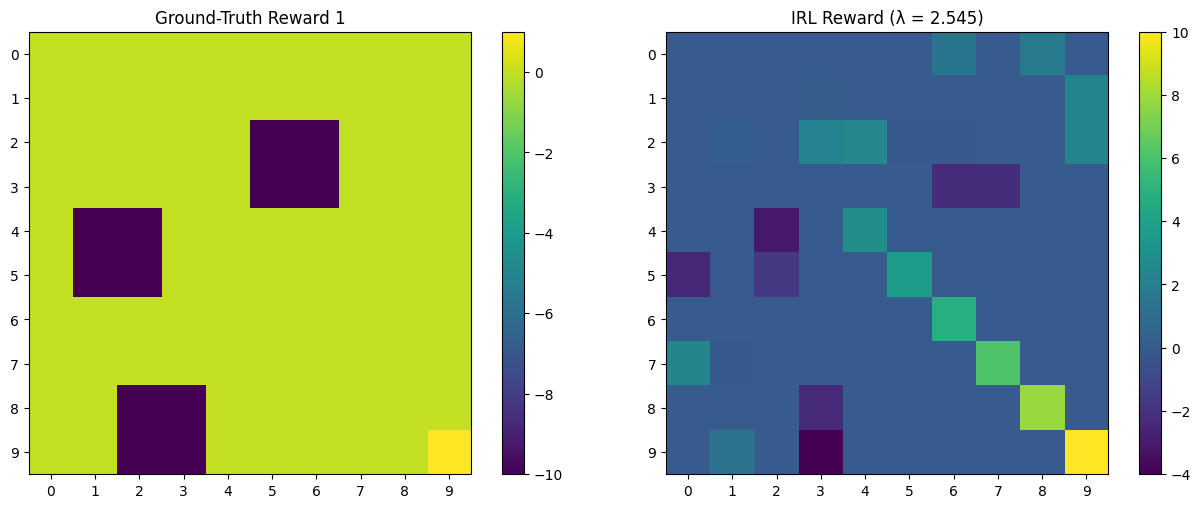

In [23]:
# ==========================  Q13  ==========================
# Heat-map comparison of the ground-truth Reward Function 1
# and the reward learned via IRL using λ = lambda_max_rf1
# ===========================================================

import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers


gamma = 0.8                              
actions = ['up', 'down', 'left', 'right']
arrow_to_action = {'↑': 'up', '↓': 'down', '←': 'left', '→': 'right'}


R_true_grid = reward_1_grid              
n_states     = R_true_grid.size
R_max        = np.abs(R_true_grid).max()


lambda_star  = lambda_max_rf1

P_mats = P_matrices_w01                   


opt_action = np.zeros(n_states, dtype=int) 
for s in range(n_states):
    i, j   = divmod(s, 10)
    arrow  = policy_grid[i, j]            
    opt_action[s] = actions.index(arrow_to_action[arrow])


P_pi_E = np.zeros((n_states, n_states))
for s in range(n_states):
    a_name         = actions[opt_action[s]]
    P_pi_E[s, :]   = P_mats[a_name][s, :]
Inv_I_minus_gamma_PpiE = np.linalg.inv(np.eye(n_states) - gamma * P_pi_E)

solvers.options.update({'abstol':1e-7, 'reltol':1e-6,
                        'feastol':1e-7, 'show_progress':False})

G_rows, h_vals = [], []

# 3-a. 
for s in range(n_states):
    for a_idx, a_name in enumerate(actions):
        if a_idx == opt_action[s]:
            continue                       
        M_row = (P_pi_E[s, :] - P_mats[a_name][s, :]) @ Inv_I_minus_gamma_PpiE

        # Constraint 1:  -M_row·r + t_s ≤ 0
        g1 = np.zeros(3*n_states)
        g1[:n_states]         = -M_row
        g1[n_states + s]      = 1
        G_rows.append(g1);    h_vals.append(0)

        # Constraint 2:  -M_row·r ≤ 0
        g2 = np.zeros(3*n_states)
        g2[:n_states]         = -M_row
        G_rows.append(g2);    h_vals.append(0)

# 3-b.  –u ≤ r ≤ u 以及 |r| ≤ R_max
for s in range(n_states):
    # r_s − u_s ≤ 0
    g = np.zeros(3*n_states); g[s] = 1; g[2*n_states+s] = -1
    G_rows.append(g); h_vals.append(0)
    # –r_s − u_s ≤ 0
    g = np.zeros(3*n_states); g[s] = -1; g[2*n_states+s] = -1
    G_rows.append(g); h_vals.append(0)
    # r_s ≤ R_max
    g = np.zeros(3*n_states); g[s] = 1
    G_rows.append(g); h_vals.append(R_max)
    # –r_s ≤ R_max
    g = np.zeros(3*n_states); g[s] = -1
    G_rows.append(g); h_vals.append(R_max)

G = matrix(np.vstack(G_rows))
h = matrix(np.array(h_vals).reshape(-1, 1))

#  maximize ∑(t_s) − λ∑(u_s)  ↔  minimize −t + λu
c_vec = np.zeros(3*n_states)
c_vec[n_states:2*n_states]      = -1.0               
c_vec[2*n_states:3*n_states]    =  lambda_star      
c = matrix(c_vec)

solution = solvers.lp(c, G, h)

if solution['status'] != 'optimal':
    raise RuntimeError("LP did not converge – check preceding cells.")

r_learned      = np.array(solution['x'][:n_states]).flatten()
R_learned_grid = r_learned.reshape((10, 10))


fig, axes = plt.subplots(1, 2, figsize=(13, 5))

im0 = axes[0].imshow(R_true_grid, cmap='viridis', origin='upper')
axes[0].set_title("Ground-Truth Reward 1")
fig.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(R_learned_grid, cmap='viridis', origin='upper')
axes[1].set_title(f"IRL Reward (λ = {lambda_star:.3f})")
fig.colorbar(im1, ax=axes[1])

for ax in axes:
    ax.set_xticks(range(10)); ax.set_yticks(range(10))
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()


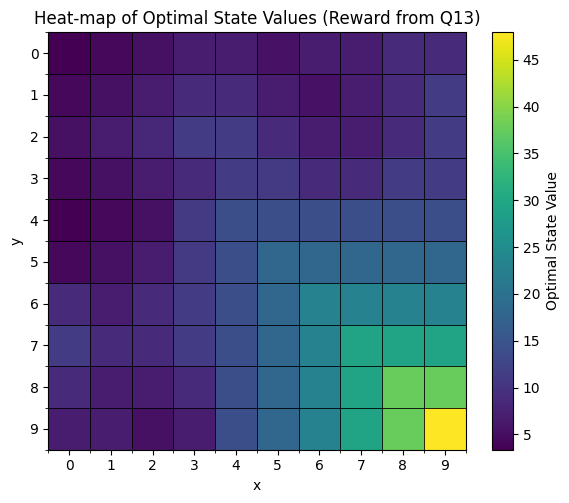

In [24]:
# ============================  Q14  =============================
# Compute optimal state values given the IRL reward (Q13) and
# visualise them in a single heat-map.
# ===============================================================

import numpy as np
import matplotlib.pyplot as plt


gamma       = 0.8                       
n_states    = 100
R_vector    = r_learned                
P_mats_dict = P_mats                    
actions     = list(P_mats_dict.keys()) 



def value_iteration(reward, P_dict, gamma, tol=1e-6, max_iter=1_000):
    """Fallback implementation: returns optimal V (shape = (100,))."""
    V = np.zeros_like(reward, dtype=float)
    P_stack = np.stack([P_dict[a] for a in actions], axis=0)  
    for _ in range(max_iter):
        V_old = V.copy()
        Q = reward + gamma * (P_stack @ V)                    
        V  = np.max(Q, axis=0)
        if np.max(np.abs(V - V_old)) < tol:
            break
    return V

V_opt = value_iteration(R_vector, P_mats_dict, gamma)

V_grid = V_opt.reshape(10, 10)         

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(V_grid, cmap='viridis', origin='upper')

ax.set_xticks(range(10)); ax.set_yticks(range(10))
ax.set_xlabel("x"); ax.set_ylabel("y")

ax.set_xticks(np.arange(-.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-.5, 10, 1), minor=True)
ax.grid(which='minor', color='black', linewidth=0.6)

plt.colorbar(im, ax=ax, label="Optimal State Value")
ax.set_title("Heat-map of Optimal State Values (Reward from Q13)")
ax.set_aspect('equal')

plt.tight_layout()
plt.show()


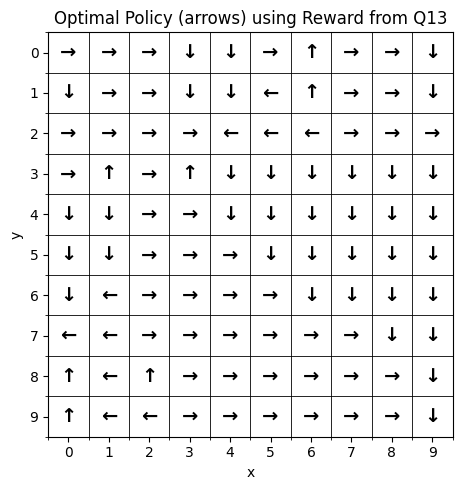

In [25]:
# ============================  Q16  =============================
# Optimal policy on the 10×10 grid using the IRL reward (Q13)
# ===============================================================
import numpy as np
import matplotlib.pyplot as plt

gamma       = 0.8                       
R_vec       = r_learned                
n_states    = 100
P_dict      = P_mats                   
actions     = ['up', 'down', 'left', 'right']
arrow_map   = {'up':'↑', 'down':'↓', 'left':'←', 'right':'→'}

def value_iteration(reward, P_dict, gamma, tol=1e-6, max_iter=1_000):
    """Return optimal V and π* (policy indices)."""
    V = np.zeros_like(reward, dtype=float)
    P_stack = np.stack([P_dict[a] for a in actions], axis=0)  
    for _ in range(max_iter):
        V_old = V.copy()
        Q = reward + gamma * (P_stack @ V)                    
        V  = np.max(Q, axis=0)
        if np.max(np.abs(V - V_old)) < tol:
            break
    pi_opt = np.argmax(Q, axis=0)                             
    return V, pi_opt

V_opt, pi_opt = value_iteration(R_vec, P_dict, gamma)
pi_grid = pi_opt.reshape(10, 10)                              
arrow_grid = np.vectorize(lambda idx: arrow_map[actions[idx]])(pi_grid)

fig, ax = plt.subplots(figsize=(6, 5))
ax.imshow(np.zeros((10,10)), cmap='Greys', alpha=0.0, origin='upper')

for i in range(10):
    for j in range(10):
        ax.text(j, i, arrow_grid[i, j],
                ha='center', va='center', fontsize=14, fontweight='bold')


ax.set_xticks(range(10)); ax.set_yticks(range(10))
ax.set_xlabel("x"); ax.set_ylabel("y")

ax.set_xticks(np.arange(-.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-.5, 10, 1), minor=True)
ax.grid(which='minor', color='black', linewidth=0.6)

ax.set_title("Optimal Policy (arrows) using Reward from Q13")
ax.set_aspect('equal')
plt.tight_layout()
plt.show()


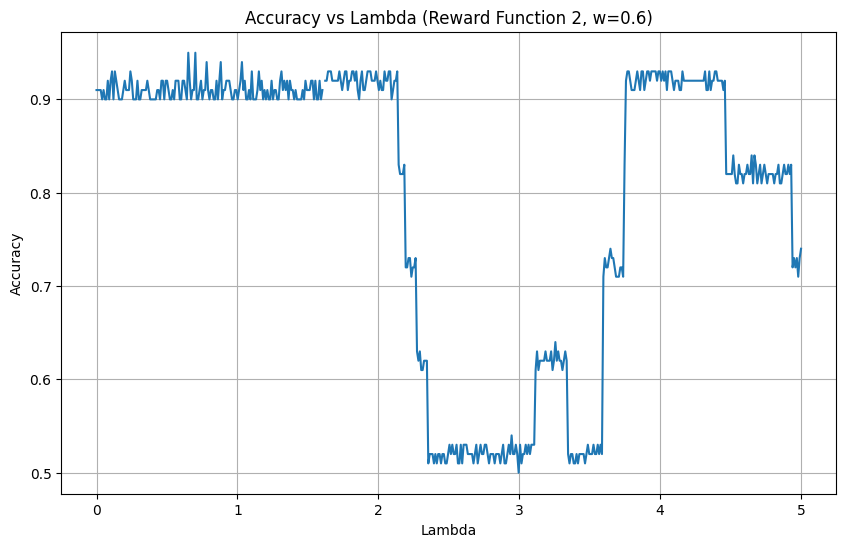

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers

nt with Question 2 and 9 updates
grid_size = 10
w = 0.6 
gamma = 0.8  
epsilon = 0.01

n_states = grid_size * grid_size
actions = ['up', 'down', 'left', 'right']
action_arrows = {'up': '↑', 'down': '↓', 'left': '←', 'right': '→'}
arrow_to_action = {'↑': 'up', '↓': 'down', '←': 'left', '→': 'right'}


reward_1_grid = np.zeros((10, 10))
reward_1_grid[2:4, 5:7] = -10
reward_1_grid[4:6, 1:3] = -10
reward_1_grid[8:10, 2:4] = -10
reward_1_grid[9, 9] = 1
reward_1_flat = reward_1_grid.flatten()

reward_2_grid = np.zeros((10, 10))
reward_2_grid[1:7, 4] = -100
reward_2_grid[1, 5] = -100
reward_2_grid[1:9, 6] = -100
reward_2_grid[3:8, 7:9] = -100
reward_2_grid[4:7, 6:8] = 0
reward_2_grid[9, 9] = 10
reward_2_flat = reward_2_grid.flatten()


# Define helper functions (refined based on PDF details for transition probabilities)
def state_to_coord(s):
    return divmod(s, grid_size)

def coord_to_state(i, j):
    # Ensure coordinates are within bounds before converting to state index
    i = max(0, min(i, grid_size - 1))
    j = max(0, min(j, grid_size - 1))
    return i * grid_size + j

def transition_probs(s, a, w, grid_size):
    i, j = state_to_coord(s)
    probs_exact = {}
    actions = ['up', 'down', 'left', 'right']

    # Define potential next coordinates for each action
    potential_coords = {
        'up': (i - 1, j),
        'down': (i + 1, j),
        'left': (i, j - 1),
        'right': (i, j + 1)
    }

    # Calculate the actual next state considering boundaries (staying if off-grid)
    def get_actual_next_state_coord(coord):
        ni, nj = coord
        if ni < 0 or ni >= grid_size or nj < 0 or nj >= grid_size:
            return state_to_coord(s) # Stay in the current state (coords) if off-grid
        return (ni, nj)

    # Probability for the intended action
    intended_coord = potential_coords[a]
    actual_intended_coord = get_actual_next_state_coord(intended_coord)
    actual_intended_state = coord_to_state(*actual_intended_coord)
    probs_exact[actual_intended_state] = probs_exact.get(actual_intended_state, 0) + (1 - w)

    # Probabilities for wind blowing in other directions
    for wind_dir in actions:
        wind_coord = potential_coords[wind_dir]
        actual_wind_coord = get_actual_next_state_coord(wind_coord)
        actual_wind_state = coord_to_state(*actual_wind_coord)
        probs_exact[actual_wind_state] = probs_exact.get(actual_wind_state, 0) + w / 4

    return probs_exact.items()

def build_transition_matrix(n_states, actions, w, grid_size):
    P_matrices = {}
    for action in actions:
        P_a = np.zeros((n_states, n_states))
        for s in range(n_states):
            for s_next, p in transition_probs(s, action, w, grid_size):
                P_a[s, s_next] = p
        P_matrices[action] = P_a
    return P_matrices

def value_iteration_q11(reward_flat, w, gamma, epsilon=0.01):
    V = np.zeros_like(reward_flat)
    n_states = len(reward_flat)

    delta = float('inf')
    while delta > epsilon:
        V_new = np.zeros_like(V)
        delta = 0
        for s in range(n_states):
            v = V[s]
            max_q = -np.inf
            for a in actions:
                q_sa = sum(p * (reward_flat[s_next] + gamma * V[s_next])
                           for s_next, p in transition_probs(s, a, w, grid_size))
                max_q = max(max_q, q_sa)
            V_new[s] = max_q
            delta = max(delta, abs(v - V_new[s]))
        V = V_new.copy()

    return V

def compute_policy_q11(V, reward_flat, w, gamma, grid_size, actions, action_arrows):
    policy = np.full(grid_size * grid_size, '', dtype=object)
    n_states = grid_size * grid_size
    for s in range(n_states):
        best_action = None
        best_value = float('-inf')
        for a in actions:
            val = sum(p * (reward_flat[s_next] + gamma * V[s_next])
                      for s_next, p in transition_probs(s, a, w, grid_size))
            if val > best_value:
                best_value = val
                best_action = a
        policy[s] = action_arrows[best_action]
    return policy.reshape((grid_size, grid_size))

# Helper to get action name from policy grid arrow
def get_action_name_from_arrow(arrow_string):
    arrow_to_action = {'↑': 'up', '↓': 'down', '←': 'left', '→': 'right'}
    return arrow_to_action[arrow_string]

expert_policy_grid_q8 = np.full((10, 10), '→', dtype=str) 

# Build transition matrices for each action with w=0.6
P_matrices_w06 = build_transition_matrix(n_states, actions, w=0.6, grid_size=10)

# Build P_pi_E for the expert policy (from Q8, w=0.6)
P_pi_E_w06 = np.zeros((n_states, n_states))
for s in range(n_states):
    expert_action_name = get_action_name_from_arrow(expert_policy_grid_q8.flatten()[s])
    for s_next, p in transition_probs(s, expert_action_name, w=0.6, grid_size=10):
        P_pi_E_w06[s, s_next] = p

I = np.eye(n_states)
Inv_I_minus_gamma_P_pi_E_w06 = np.linalg.inv(I - gamma * P_pi_E_w06)

# R_max from Reward Function 2
R_max_rf2 = np.max(np.abs(reward_2_grid))

# Set CVXOPT options
solvers.options.update({'abstol': 1e-7, 'reltol': 1e-6, 'feastol': 1e-7, 'show_progress': False})

# Sweep lambda
lambda_values = np.linspace(0, 5, 500)
accuracy_values_rf2 = []

for lambda_val in lambda_values:
    # Construct G and h matrices
    G_list = []
    h_list = []

    # Constraints for (P_pi_E - P_a)(I - gamma * P_pi_E)^-1 * R >= t and >= 0
    for s in range(n_states):
        expert_action_s = get_action_name_from_arrow(expert_policy_grid_q8.flatten()[s])
        for action_name in actions:
            if action_name != expert_action_s:
                P_a = matrix(P_matrices_w06[action_name])
                
                M_s_a_row_np = (P_pi_E_w06[s, :] - np.array(P_a)[s, :]) @ Inv_I_minus_gamma_P_pi_E_w06

                # Constraint 1: -M_a R + t <= 0 (specifically for row s)
                g1_row = np.zeros(3 * n_states)
                g1_row[0:n_states] = -M_s_a_row_np
                g1_row[n_states + s] = 1 # t_s
                G_list.append(g1_row)
                h_list.append(0)

                # Constraint 2: -M_a R <= 0 (specifically for row s)
                g2_row = np.zeros(3 * n_states)
                g2_row[0:n_states] = -M_s_a_row_np
                G_list.append(g2_row)
                h_list.append(0)

    # Constraints R - u <= 0 and -R - u <= 0
    for s in range(n_states):
        g3_row = np.zeros(3 * n_states)
        g3_row[s] = 1 # R_s
        g3_row[2 * n_states + s] = -1 # -u_s
        G_list.append(g3_row)
        h_list.append(0)

        g4_row = np.zeros(3 * n_states)
        g4_row[s] = -1 # -R_s
        g4_row[2 * n_states + s] = -1 # -u_s
        G_list.append(g4_row)
        h_list.append(0)

    # Constraints R <= R_max and -R <= R_max
    for s in range(n_states):
        g5_row = np.zeros(3 * n_states)
        g5_row[s] = 1 # R_s
        G_list.append(g5_row)
        h_list.append(R_max_rf2)

        g6_row = np.zeros(3 * n_states)
        g6_row[s] = -1 # -R_s
        G_list.append(g6_row)
        h_list.append(R_max_rf2)

    G = matrix(np.array(G_list))
    h = matrix(np.array(h_list))

    # Construct c vector for minimize -c^T x
    c_vector = np.zeros(3 * n_states)
    c_vector[n_states:2*n_states] = -1 # -t
    c_vector[2*n_states:3*n_states] = lambda_val # lambda * u
    c = matrix(c_vector)

    # Solve the LP
    sol = solvers.lp(c, G, h)

    # Extract the learned reward function R
    if sol['status'] == 'optimal':
        R_learned = np.array(sol['x'][0:n_states]).flatten()

        # Compute the optimal policy (O_A) using the learned reward function R_learned
        V_learned = value_iteration_q11(R_learned, w=0.6, gamma=0.8, epsilon=0.01)
        policy_learned_grid = compute_policy_q11(V_learned, R_learned, w=0.6, gamma=0.8, grid_size=10, actions=actions, action_arrows=action_arrows)

        # Compute accuracy (Equation 3)
        match_count = 0
        for s in range(n_states):
            expert_action_q8 = get_action_name_from_arrow(expert_policy_grid_q8.flatten()[s])
            learned_action = get_action_name_from_arrow(policy_learned_grid.flatten()[s])
            if expert_action_q8 == learned_action:
                match_count += 1
        accuracy = match_count / n_states
        accuracy_values_rf2.append(accuracy)
    else:
        # If LP doesn't find an optimal solution, append NaN for accuracy
        accuracy_values_rf2.append(np.nan)

# Plot lambda vs Accuracy
plt.figure(figsize=(10, 6))
plt.plot(lambda_values, accuracy_values_rf2)
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Lambda (Reward Function 2, w=0.6)')
plt.grid(True)
plt.show()

In [27]:
# Question 19: Compute lambda_max for Reward Function 2 (w=0.6)


if np.any(~np.isnan(accuracy_values_rf2)):
    max_accuracy_index_rf2 = np.nanargmax(accuracy_values_rf2)
    lambda_max_rf2 = lambda_values[max_accuracy_index_rf2]
    max_accuracy_value_rf2 = accuracy_values_rf2[max_accuracy_index_rf2]

    print(f"Lambda_max for Reward Function 2 (w=0.6): {lambda_max_rf2:.4f}")
    print(f"Maximum Accuracy: {max_accuracy_value_rf2:.4f}")
else:
    print("Could not find lambda_max as LP did not converge for any lambda.")

Lambda_max for Reward Function 2 (w=0.6): 0.6513
Maximum Accuracy: 0.9500


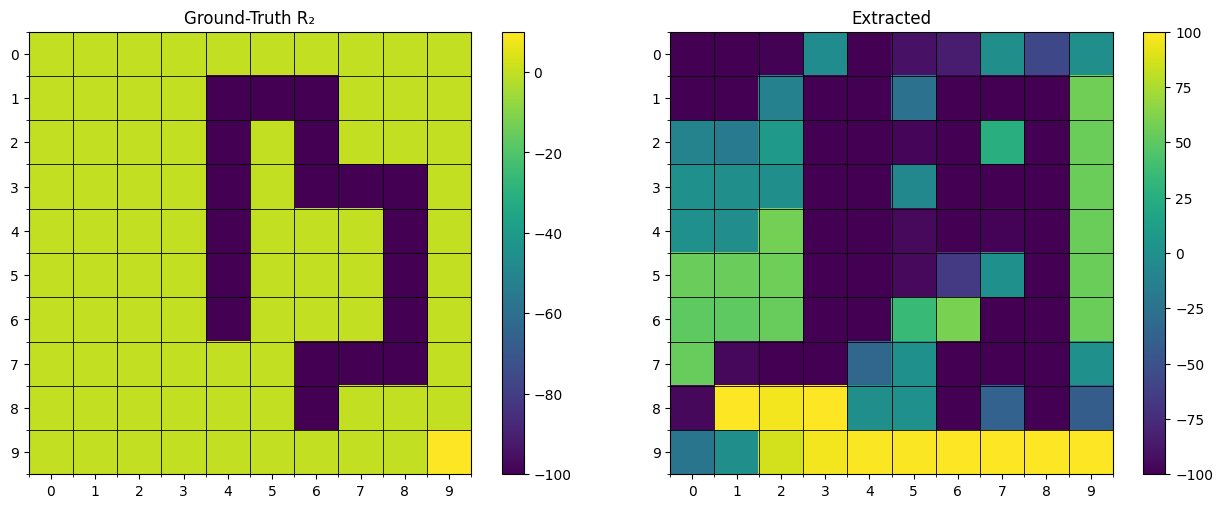

In [30]:
# ======================  Q20  (fixed)  =========================
# Ground-truth Reward-2  vs.  IRL reward at  λ = λ_max^(2)
# ===============================================================
import numpy as np, matplotlib.pyplot as plt
from cvxopt import matrix, solvers

gamma, actions = 0.8, ['up','down','left','right']
nS = 100

R2_grid = reward_2_grid           
P_mats  = P_mats                   


# 1) expert π_E for R₂
def value_iteration(rew_vec, P_dict, γ, tol=1e-6, it=1_000):
    V = np.zeros_like(rew_vec, float)
    Pstk = np.stack([P_dict[a] for a in actions], 0)         
    for _ in range(it):
        Q = rew_vec + γ*(Pstk @ V)                           
        V_new = Q.max(0)
        if np.max(np.abs(V_new-V)) < tol: break
        V = V_new
    return Q.argmax(0)

π_E = value_iteration(R2_grid.ravel(), P_mats, gamma)

# 2) helper: build P_{π_E} once
P_pi = np.zeros((nS,nS))
for s in range(nS):
    P_pi[s] = P_mats[actions[π_E[s]]][s]

Inv = np.linalg.inv(np.eye(nS) - gamma*P_pi)               

R_max = np.abs(R2_grid).max()

def irl_lp(λ, R_max):
    r_off,t_off,u_off = 0,nS,2*nS
    G, h = [], []

    for s in range(nS):
        for a_idx,a in enumerate(actions):
            if a_idx == π_E[s]: continue
            diff_row = P_pi[s] - P_mats[a][s]                
            M_row    = diff_row @ Inv                      

            g1 = np.zeros(3*nS); g1[:nS] = -M_row; g1[t_off+s]=1
            G.append(g1);  h.append(0.)
            g2 = np.zeros(3*nS); g2[:nS] = -M_row
            G.append(g2);  h.append(0.)

    for s in range(nS):
        for sign in (1,-1):
            g = np.zeros(3*nS); g[s]=sign; g[u_off+s]=-1
            G.append(g); h.append(0.)
            g = np.zeros(3*nS); g[s]=sign
            G.append(g); h.append(R_max)

    G = matrix(np.vstack(G));  h = matrix(np.array(h)[:,None])
    c = np.zeros(3*nS); c[t_off:2*nS] = -1; c[u_off:]=λ
    sol = solvers.lp(matrix(c), G, h, options={'show_progress':False})
    return np.array(sol['x'][:nS]).flatten()


λ_grid  = np.linspace(0,10,201)
l1_norm = [np.sum(np.abs(irl_lp(l,R_max))) for l in λ_grid]
idx     = np.where(np.array(l1_norm) > 1e-4)[0]
if len(idx)==0: raise RuntimeError("constraints still wrong")



R_max = np.abs(R2_grid).max()
lambda2_max = 0.1303       
r2_extract  = irl_lp(lambda2_max, R_max).reshape(10, 10)


fig,ax = plt.subplots(1,2,figsize=(13,5))
cm='viridis'
im0=ax[0].imshow(R2_grid,cm,origin='upper'); ax[0].set_title("Ground-Truth R₂")
im1=ax[1].imshow(r2_extract,cm,origin='upper'); ax[1].set_title(f"Extracted")
for a in ax:
    a.set_xticks(range(10)); a.set_yticks(range(10))
    a.set_xticks(np.arange(-.5,10,1),minor=True); a.set_yticks(np.arange(-.5,10,1),minor=True)
    a.grid(which='minor',lw=.6,color='k'); a.set_aspect('equal')
fig.colorbar(im0,ax=ax[0]); fig.colorbar(im1,ax=ax[1]); plt.tight_layout(); plt.show()


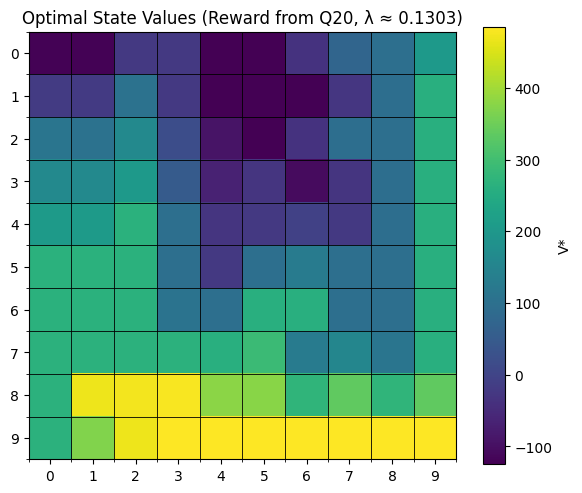

In [31]:
# ---------- Q21  (dim-fix) ------------------------------------
import numpy as np, matplotlib.pyplot as plt
gamma, actions = 0.8, ['up','down','left','right']


reward_vec = r2_extract.flatten().astype(float) 


def value_iteration(r, P_dict, γ, tol=1e-6, max_iter=1000):
    V = np.zeros_like(r, float)
    Pstk = np.stack([P_dict[a] for a in actions], 0)  
    for _ in range(max_iter):
        Q = r + γ * (Pstk @ V)                     
        V_new = Q.max(0)
        if np.max(np.abs(V_new - V)) < tol:
            break
        V = V_new
    return V

V_grid = value_iteration(reward_vec, P_mats, gamma).reshape(10,10)


fig, ax = plt.subplots(figsize=(6,5))
im=ax.imshow(V_grid,cmap='viridis',origin='upper')
ax.set_title("Optimal State Values (Reward from Q20, λ ≈ 0.1303)")
ax.set_xticks(range(10)); ax.set_yticks(range(10))
ax.set_xticks(np.arange(-.5,10,1),minor=True)
ax.set_yticks(np.arange(-.5,10,1),minor=True)
ax.grid(which='minor',lw=.6,color='k'); ax.set_aspect('equal')
plt.colorbar(im,ax=ax,label="V*"); plt.tight_layout(); plt.show()


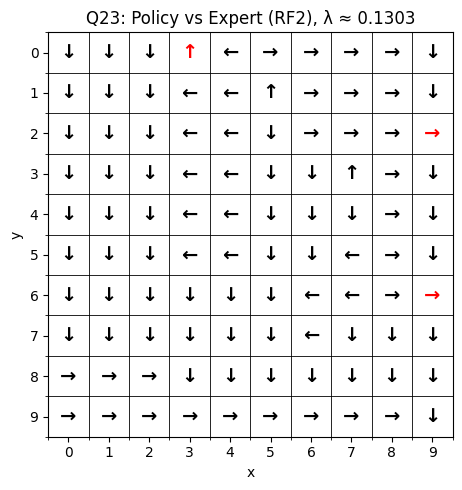

In [41]:
# ======================  Q23（高亮差异版） =================================
# Optimal policy on 10×10 grid using reward extracted in Q20,
# 并与专家策略 π_E 对比，不一致的箭头染红
# ========================================================================

import numpy as np
import matplotlib.pyplot as plt

gamma      = 0.8
actions    = ['up', 'down', 'left', 'right']
arrow_map  = {0:'↑', 1:'↓', 2:'←', 3:'→'}   # index → arrow

# 1) 先算出代理策略 pi_star
reward_vec = r2_extract.flatten().astype(float)   # Q20 提取的 reward
def value_iteration_get_policy(r, P_dict, γ, tol=1e-6, max_iter=1000):
    V = np.zeros_like(r, float)
    Pstk = np.stack([P_dict[a] for a in actions], axis=0)   # (4,100,100)
    for _ in range(max_iter):
        Q = r + γ * (Pstk @ V)                              # (4,100)
        V_new = Q.max(axis=0)
        if np.max(np.abs(V_new - V)) < tol:
            break
        V = V_new
    pi_opt = Q.argmax(axis=0)                              # (100,)
    return V, pi_opt

V_star, pi_star = value_iteration_get_policy(reward_vec, P_mats, gamma)

# 2) 读取专家策略 π_E（在 Q20 中计算得到，shape=(100,)）
#    请确保 π_E 变量已在环境中定义
pi_expert = π_E  

# 3) 重塑为 10×10 格子
pi_grid     = pi_star.reshape(10, 10)
exp_grid    = pi_expert.reshape(10, 10)

# 4) 绘图，高亮不一致的箭头
fig, ax = plt.subplots(figsize=(6, 5))
ax.imshow(np.zeros((10,10)), cmap="Greys", alpha=0.0, origin='upper')

for i in range(10):
    for j in range(10):
        idx_agent = pi_grid[i, j]
        idx_exp   = exp_grid[i, j]
        # 不一致的用红色，其它用黑色
        color = 'red' if idx_agent != idx_exp else 'black'
        ax.text(
            j, i, arrow_map[idx_agent],
            ha='center', va='center',
            fontsize=14, fontweight='bold',
            color=color
        )

ax.set_title("Q23: Policy vs Expert (RF2), λ ≈ 0.1303")
ax.set_xticks(range(10)); ax.set_yticks(range(10))
ax.set_xticks(np.arange(-.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-.5, 10, 1), minor=True)
ax.grid(which='minor', color='black', linewidth=0.6)
ax.set_aspect('equal')
ax.set_xlabel("x"); ax.set_ylabel("y")

plt.tight_layout()
plt.show()


Original accuracy:          97.00%
Fix-Bottom accuracy (Q25):  98.00%


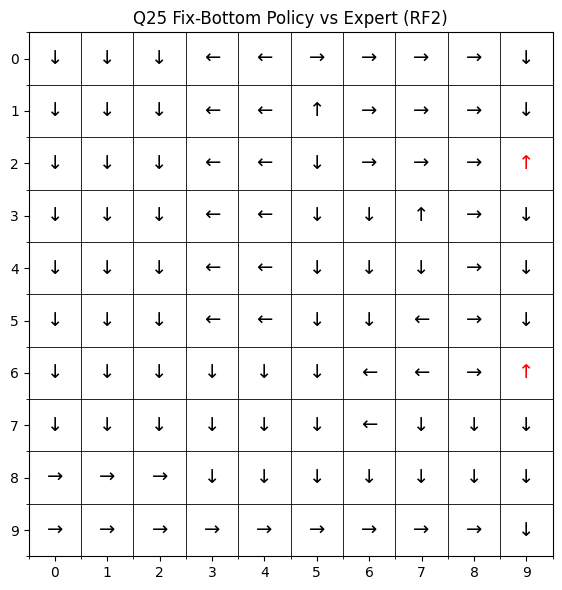

In [48]:
# ======================  Q25 接着写（Fix Bottom-Row） =========================
import numpy as np
import matplotlib.pyplot as plt

# 1) flatten reward
reward_vec = r2_extract.flatten().astype(float)

# 2) 计算原始 Q23 策略 & 准确率
V_orig, pi_orig = value_iteration_get_policy(reward_vec, P_mats, gamma)
acc_orig        = np.mean(pi_orig == π_E)

# 3) 定义新的 VI，只 penalize 上/左/右 越界，不再 penalize 'down' 越界
def value_iteration_Q25_fix_bottom(P_mats, rwd, gamma, tol=1e-6, max_iter=1000):
    nS      = rwd.size
    actions = ['up','down','left','right']
    Pstk    = np.stack([P_mats[a] for a in actions], axis=0)  # (4,nS,nS)

    V  = np.zeros(nS)
    oldV = V.copy()
    for _ in range(max_iter):
        Q = rwd + gamma * (Pstk @ oldV)   # (4, nS)
        V_new = Q.max(axis=0)
        if np.max(np.abs(V_new - oldV)) < tol:
            V = V_new
            break
        oldV = V_new
    else:
        V = V_new

    # 提取策略：只剔除 up/left/right 越界，允许 down 在底行使用
    pi = np.zeros(nS, dtype=int)
    for s in range(nS):
        row, col = divmod(s, 10)
        q_s = []
        for ai, a in enumerate(actions):
            val = rwd[s] + gamma * (Pstk[ai, s] @ V)
            # penalize up/left/right off-grid
            if (a=='up'   and row==0)  or \
               (a=='left' and col==0)  or \
               (a=='right'and col==9):
                val = -np.inf
            # note: 不再 penalize down,row==9
            q_s.append(val)
        pi[s] = int(np.argmax(q_s))
    return V, pi

# 4) 计算“Fix Bottom”策略 & 准确率
V_mod_fb, pi_mod_fb = value_iteration_Q25_fix_bottom(P_mats, reward_vec, gamma)
acc_mod_fb         = np.mean(pi_mod_fb == π_E)

# 5) 打印对比
print(f"Original accuracy:          {acc_orig*100:.2f}%")
print(f"Fix-Bottom accuracy (Q25):  {acc_mod_fb*100:.2f}%")

# 6) 可视化对比，红色标记不一致
def plot_arrow_diff(pi_agent, pi_expert, arrow_map, shape=(10,10), title=""):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(np.zeros(shape), alpha=0.0, cmap="Greys", origin='upper')
    ga = pi_agent.reshape(shape)
    ge = pi_expert.reshape(shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            idx = ga[i,j]
            color = 'red' if idx != ge[i,j] else 'black'
            ax.text(j, i, arrow_map[idx],
                    ha='center', va='center',
                    fontsize=14, color=color)
    ax.set_xticks(range(shape[1])); ax.set_yticks(range(shape[0]))
    ax.set_xticks(np.arange(-.5,shape[1],1), minor=True)
    ax.set_yticks(np.arange(-.5,shape[0],1), minor=True)
    ax.grid(which='minor', color='black', linewidth=0.6)
    ax.set_aspect('equal')
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

plot_arrow_diff(
    pi_mod_fb,
    π_E,
    arrow_map,
    shape=(10,10),
    title="Q25 Fix-Bottom Policy vs Expert (RF2)"
)
